<a href="https://colab.research.google.com/github/MukRodrigues/Simulacao-difusao-reacao/blob/main/GITHUB_Simulacao_equacao_difusao_reacao_logisitca_crank_nicolson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#pacotes de funções usadas
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, sin, pi, linalg
import timeit
import matplotlib.cm as cm

from ipywidgets import interact, interactive, fixed, widgets
from IPython.display import display

# Simulação Numérica


In [14]:
# parâmetros
L = 1
T = 20
k = 0.04  #quanto menor, maior o tempo de processamento!
h = 0.002
gamma1 = k/(4*h)
gamma2 = k/(2*h**2)

# Malha
x = np.arange(0,L+h,h)   #dessa forma, adaptando os steps, dá pra definir qualquer intervalo em x
x0 = (min(x) + max(x))/2
t = np.arange(0,T+k,k)

n = len(x) #tamanhos dos vetores
m = len(t)

#[m,n, round(x0,3)]

Vamos fazer a simulação da solução numérica da equação

\begin{eqnarray}
\begin{cases}
\partial _t \rho &=& \partial_x (D(x,t) \partial _x \rho) + f(x,t,\rho) \\
\rho(0,t) &=& \rho(L,t) = 0 \\
\rho(x,0) &=& \frac{N_0}{L}
\end{cases}
\end{eqnarray}

com $(x,t) \in [0,L] \times \mathbb{R}_+$, $L>0$, e $N_0$ correspondendo ao tamanho inicial da população. Considerando a função fonte logística $f(x,t,\rho)$ na forma:

\begin{eqnarray}
f &=& r(t)\rho(x,t) \left(1 - \frac{\rho(x,t)}{K(t)}\right)
\end{eqnarray}

## Difusão variável com crecimento logístico

A discretização da EDP com o método de Crank-Nilson fica

\begin{eqnarray}
 (-\gamma_1 E ^{j+1/2}_{i} - \gamma_2 D^{j+1/2}_{i}) \rho^{j+1}_{i+1} + (1 + 2 \gamma_2 D^{j+1/2}_{i}) \rho^{j+1}_{i} + (\gamma_1 E ^{j+1/2}_{i} - \gamma_2 D^{j+1/2}_{i}) \rho^{j+1}_{i-1} = (\gamma_1 E ^{j+1/2}_{i} + \gamma_2 D^{j+1/2}_{i})\rho^{j}_{i+1} +(r^{j+1/2}- 2 \gamma_2 D^{j+1/2}_{i}) \rho^{j}_{i} + (-\gamma_1 E ^{j+1/2}_{i} + \gamma_2 D^{j+1/2}_{i}) \rho^{j}_{i-1} + k\ r^{j+1/2}_{i}\rho^{j}_{i} \left( 1 - \frac{ \rho^{j} _{i} }{ K^{j+1/2}_{i}} \right).
\end{eqnarray}

 com $h=\Delta x$, $k=\Delta t$, $\gamma_1 = k / 4h$ e $\gamma_2 = k / 2h^2$.

 A forma matricial da solução fica

 $$
 A \rho^{j+1} = B  \rho^{j} + F(\rho^j).
 $$



#### Funções auxiliares

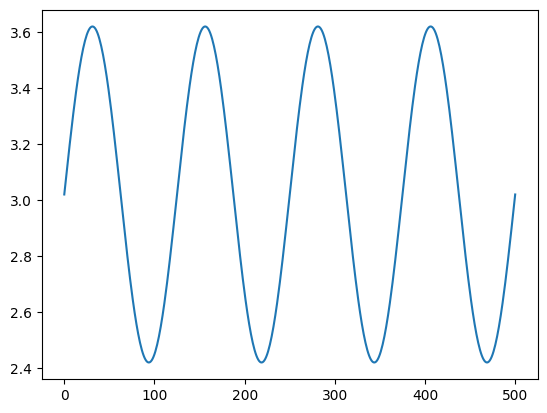

In [15]:
#suporte
k1 = 10
k2 = 0.2*k1
pk = T/2.5
K = k1 + k2*sin(2*pi*t/pk) + k/2

#tx crescimento
r1 = 3
r2 = 0.2*r1
pr = 5 #periodo oscilação crescimento
r = r1 + r2*sin(2*pi*t/pr) + k/2

# Difusividade D(x,K) e sua derivada Dx
D0 = .5
D = np.zeros((n,m))
Dx = np.zeros((n,m))
for i in range(n):
  for j in range(m):
      D[i,j] = D0 * (exp(-K[j]*(x0 - x[i])**2 )) + k/2 #difusao
      Dx[i,j] = (-2)*(K[j])*(-x0 + x[i])* D[i,j] + k/2   #convecção?? força a densidade a se mover na direção ao maior valor de x_i

plt.plot(r)   #um plot rápido só para ver a "cara" de r e K.. só trocar o argumento do plt.plot para visualizar a função periódica
plt.show()

In [16]:
# Condições Iniciais e de Contorno
boudaryconditions = [0,0]
N0 = 5
inicialconditions = N0/L

rhol = np.zeros((n,m))
f_logi = np.zeros((n,m))
rhol[0,:] = boudaryconditions[0]  # rho(0, t)
rhol[-1,:] = boudaryconditions[1] # rho(L, t)
rhol[:,0] = inicialconditions     #rho(x,0)

rho_kmax = k1+k2 +0*x
rho_kmin =  k1- k2 +0*x

$$A \rho^{j+1} = B  \rho^{j} + F(\rho^j).$$

In [17]:
#Construção das matrizes tridiagonais
A = np.zeros((n,m))
for i in range(n):
  #A = A + np.diag([1+2*gamma2*D[i,i]],0)
    A[i,i] = 1+2*gamma2*D[i,i]   #diag. principal
    if i < n-1:
      A[i,i+1] = -gamma1*Dx[i,i+1] - gamma2*D[i,i+1]      #diag. upper
      A[i+1,i] = gamma1*Dx[i+1,i] - gamma2*D[i+1,i]      #diag. lower


B = np.zeros((n,m))
for i in range(n):
  #A = A + np.diag([1+2*gamma2*D[i,i]],0)
    B[i,i] = 1-2*gamma2*D[i,i]   #diag. principal
    if i < n-1:
      B[i,i+1] = gamma1*Dx[i,i+1] + gamma2*D[i,i+1]      #diag. upper
      B[i+1,i] = -gamma1*Dx[i+1,i] + gamma2*D[i+1,i]      #diag. lower
      #print(r[i],-2*gamma2*D[i,i])


In [18]:
# resolução do sistema não linear
for j in range(0, m-1):
  b = rhol[:,j].copy()
  Logi = rhol[:,j].copy()* k*r[j] - rhol[:,j].copy()**2 * k*r[j]/K[j]
  b = np.dot(B,b) + Logi
  b[0] = boudaryconditions[0]
  b[-1] = boudaryconditions[-1]
  solution = linalg.solve(A,b)
  rhol[:,j+1] = solution
  f_logi[:,j+1] = Logi


### Gráficos

#### Densidade

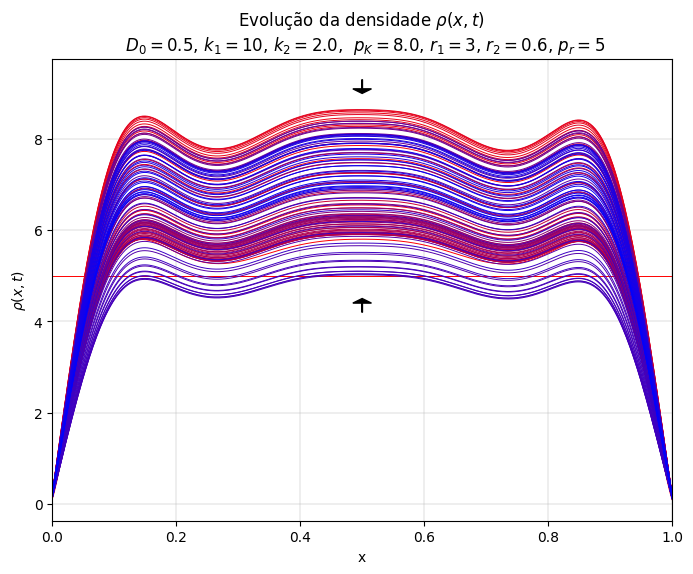

In [19]:
M = 500
colors = [(1 - i/M, 0, i/M) for i in range(M)]
plt.figure(figsize=(8, 6))

for j in range(0, M, max(1, int(M/120))):
  plt.plot(x, rhol[:,j], linewidth=0.7, color=colors[j])

#plt.plot(x, inicialconditions + 0*x, linewidth=1.5, color="black", linestyle='--')
#plt.plot(x, rho_kmax, linewidth=0.7, color="black", linestyle='--')
#plt.plot(x, rho_kmin, linewidth=0.7, color="gray", linestyle='--')

#plt.plot(x, rhol[:,T],linewidth=1.5, color="black", linestyle='--')
# $p_K=${round(pk,1)} $p_r=${round(pr,1)}
#plt.title(f'Evolução da densidade $\\rho(x,t)$ - $D_0=${D0}, $k_1 =${k1},$k_2 =${k2}, $p_K=${round(pk,1)}')
plt.title(f'Evolução da densidade $\\rho(x,t)$ \n $D_0=${D0}, $k_1 =${k1}, $k_2 =${k2},  $p_K=${round(pk,2)}, $r_1 =${r1}, $r_2 =${round(r2,1)}, $p_r=${round(pr,2)}')
plt.xlabel('x')
plt.ylabel('$\\rho(x,t)$')
plt.xlim(0,1)
#plt.ylim(6.5,7)
#plt.legend([f't = {value.round(3)}' for value in t])
plt.grid(linestyle='-', linewidth=0.3)
plt.arrow(0.5,9.3,0,-0.2, head_width=0.03,head_length=0.1, color='black') #setinha
plt.arrow(0.5,4.2,0,0.2, head_width=0.03,head_length=0.1, color='black') #setinha

#plt.savefig('difusao-_variavel_crescimento_logistico_r_var_k_var')
plt.show()
#print(f"Do tempo t={t[0]} até t={t[M].round(3)}.")